In [16]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [18]:
def generate_cmap(colors):
    
    values = range(len(colors))
    vmax = np.ceil(np.max(values))
    color_list = []
    for v, c in zip(values, colors):
        color_list.append((v/vmax, c))
    return matplotlib.colors.LinearSegmentedColormap.from_list('custom_cmap', color_list)

base_color = 'darkturquoise'
base_color2 = 'gray'
cm = generate_cmap([base_color2, 'white', base_color])

In [2]:
reader = pd.read_csv('./data/all_matches.csv', chunksize=100)

In [3]:
reader.get_chunk(5)

,start_date,end_date,location,court_surface,prize_money,currency,year,player_id,player_name,opponent_id,opponent_name,tournament,round,num_sets,sets_won,games_won,games_against,tiebreaks_won,tiebreaks_total,serve_rating,aces,double_faults,first_serve_made,first_serve_attempted,first_serve_points_made,first_serve_points_attempted,second_serve_points_made,second_serve_points_attempted,break_points_saved,break_points_against,service_games_won,return_rating,first_serve_return_points_made,first_serve_return_points_attempted,second_serve_return_points_made,second_serve_return_points_attempted,break_points_made,break_points_attempted,return_games_played,service_points_won,service_points_attempted,return_points_won,return_points_attempted,total_points_won,total_points,duration,player_victory,retirement,seed,won_first_set,doubles,masters,round_num,nation
0,2012-06-11,2012-06-17,Slovakia,Clay,30000,€,2012,adrian-partl,A. Partl,andrej-martin,A. Martin,kosice_challenger,2nd Round Qualifying,2,0,3,12,0,0,149.0,0.0,5.0,27.0,44.0,12.0,27.0,4.0,17.0,1.0,7.0,8.0,198.0,8.0,30.0,8.0,14.0,1.0,1.0,7.0,16.0,44.0,16.0,44.0,32.0,88.0,01:02:00,f,f,NaN,f,f,100,1,Slovakia
1,2012-06-11,2012-06-17,Slovakia,Clay,30000,€,2012,adrian-partl,A. Partl,jozef-kovalik,J. Kovalik,kosice_challenger,1st Round Qualifying,3,2,16,12,0,0,249.0,2.0,8.0,49.0,104.0,37.0,49.0,26.0,55.0,12.0,14.0,14.0,159.0,11.0,40.0,27.0,51.0,4.0,8.0,14.0,63.0,104.0,38.0,91.0,101.0,195.0,02:43:00,t,f,NaN,t,f,100,0,Slovakia
2,2012-06-11,2012-06-17,Slovakia,Clay,30000,€,2012,agustin-velotti,A. Velotti,dominik-hrbaty,D. Hrbaty,kosice_challenger,Round of 32,2,0,7,12,0,0,225.0,1.0,1.0,34.0,54.0,16.0,34.0,12.0,20.0,1.0,5.0,9.0,139.0,15.0,40.0,13.0,32.0,2.0,5.0,10.0,28.0,54.0,28.0,72.0,56.0,126.0,01:17:00,f,f,NaN,f,f,100,3,Slovakia
3,2012-06-11,2012-06-17,Slovakia,Clay,30000,€,2012,agustin-velotti_marcel-felder,NaN,andrei-daescu_florin-mergea,NaN,kosice_challenger,Round of 16,3,1,18,22,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,f,NaN,t,t,100,4,Slovakia
4,2012-06-11,2012-06-17,Slovakia,Clay,30000,€,2012,alessandro-giannessi,A. Giannessi,harri-heliovaara,H. Heliovaara,kosice_challenger,Round of 32,3,2,17,15,1,1,276.0,1.0,7.0,68.0,104.0,47.0,68.0,22.0,36.0,4.0,6.0,16.0,127.0,13.0,54.0,18.0,36.0,2.0,5.0,15.0,69.0,104.0,31.0,90.0,100.0,194.0,02:32:00,t,f,1.0,t,f,100,3,Slovakia


In [4]:
def preprocess(df):
    
    df = df.dropna()
    df = df[df['doubles'] == 'f']
    df = df[df['year'] >= 2017]
    df = df.drop(['start_date', 'end_date', 'location', 'prize_money', 'currency', 'player_id', 'opponent_id', 'duration', 'seed', 'nation'], axis=1)
    return df

df_matches = pd.concat((preprocess(r) for r in reader), ignore_index=True)

In [5]:
len(df_matches)

22745

In [12]:
df_tmp = df_matches[df_matches['player_name'] == 'K. Nishikori']

# 復帰前か復帰後かのフラグ
df_tmp.loc[df_tmp['year'] >= 2018, 'returned'] = True
df_tmp.loc[df_tmp['year'] < 2018, 'returned'] = False

# ダブルフォルト率
df_tmp.loc[:, 'double_faults_rate'] = df_tmp['double_faults']/(df_tmp['first_serve_points_attempted']+df_tmp['second_serve_points_attempted'])

# ファーストサービス成功率
df_tmp.loc[:, 'first_serve_rate'] = df_tmp['first_serve_made']/df_tmp['first_serve_attempted']

# ファーストサービス成功時のポイント率
df_tmp.loc[:, 'first_serve_point_rate'] = df_tmp['first_serve_points_made']/df_tmp['first_serve_points_attempted']

# セカンドサービス成功率
df_tmp.loc[:, 'second_serve_rate'] = 1-df_tmp['double_faults']/df_tmp['second_serve_points_attempted']

# セカンドサービス成功時のポイント率
df_tmp.loc[:, 'second_serve_point_rate'] = df_tmp['second_serve_points_made']/df_tmp['second_serve_points_attempted']

# 相手ファーストサービス成功時のポイント率
df_tmp.loc[:, 'first_serve_return_point_rate'] = df_tmp['first_serve_return_points_made']/df_tmp['first_serve_return_points_attempted']

# 相手セカンドサービス成功時のポイント率
df_tmp.loc[:, 'second_serve_return_point_rate'] = df_tmp['second_serve_return_points_made']/df_tmp['second_serve_return_points_attempted']

df_tmp = df_tmp[[
    'returned', 'double_faults_rate', 'first_serve_rate', 'first_serve_point_rate','second_serve_rate', 'second_serve_point_rate',
    'first_serve_return_point_rate', 'second_serve_return_point_rate'
]]

df_tmp.head()

,returned,double_faults_rate,first_serve_rate,first_serve_point_rate,second_serve_rate,second_serve_point_rate,first_serve_return_point_rate,second_serve_return_point_rate
303,False,0.012821,0.628205,0.693878,0.965517,0.586207,0.159091,0.451613
304,False,0.032609,0.630435,0.758621,0.911765,0.441176,0.344262,0.533333
305,False,0.000000,0.663043,0.704918,1.000000,0.419355,0.375000,0.680000
306,False,0.040816,0.673469,0.757576,0.875000,0.625000,0.447368,0.529412
351,False,0.000000,0.625000,0.628571,1.000000,0.523810,0.218750,0.454545


In [15]:
len(df_tmp[df_tmp['returned'] == True]), len(df_tmp[df_tmp['returned'] == False])

(27, 43)

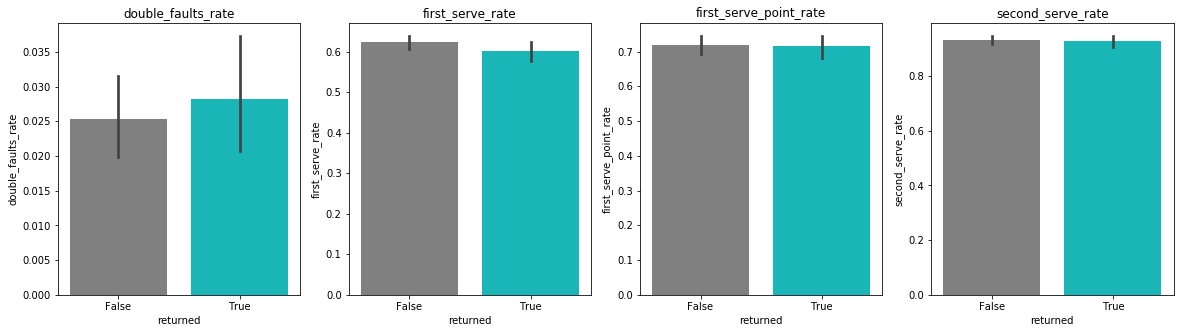

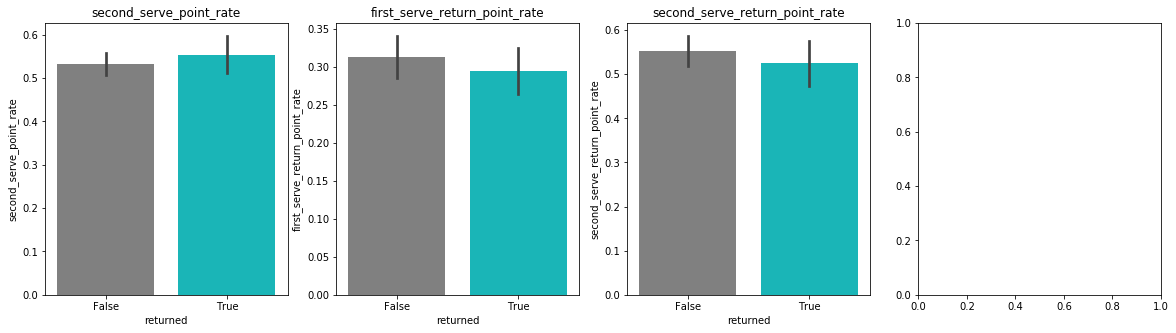

In [34]:
cols = list(df_tmp.columns)
cols.remove('returned')

for i, c in enumerate(cols):
    
    if i%4 == 0:
        fig, axs = plt.subplots(ncols=4, figsize=(20, 5))
    
    sns.barplot(data=df_tmp, x='returned', y=c, palette=[base_color2, base_color], ax=axs[i%4])
    axs[i%4].set_title(c)
    
plt.show()

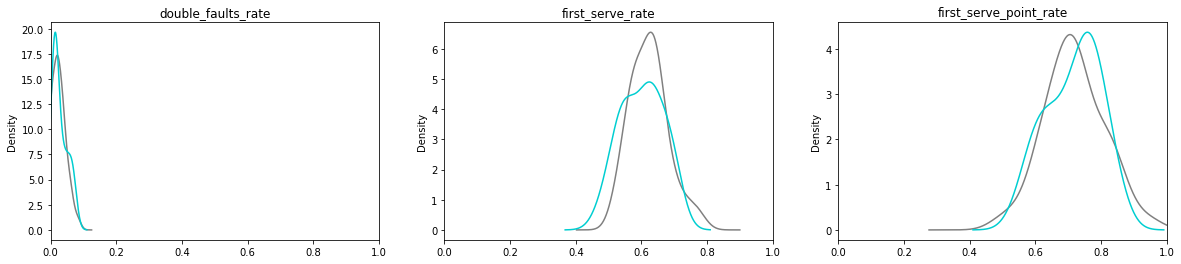

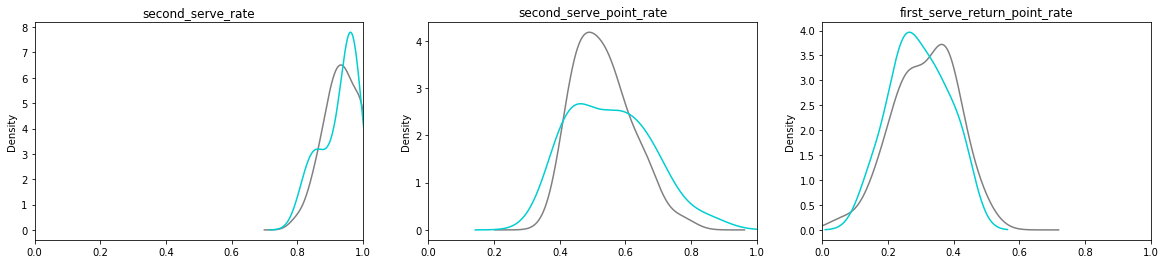

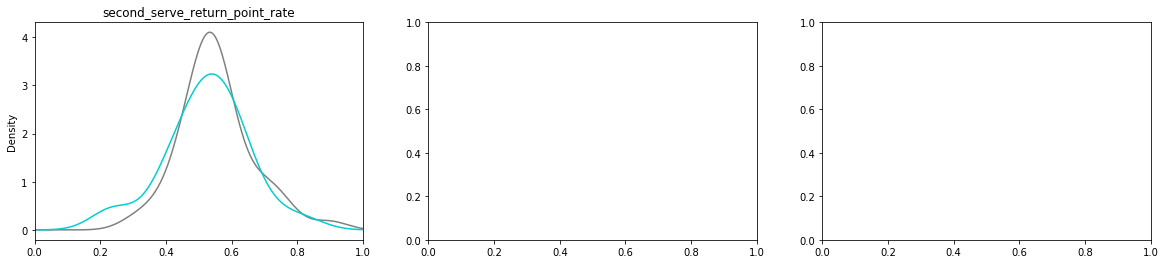

In [38]:
cols = list(df_tmp.columns)
cols.remove('returned')

for i, c in enumerate(cols):
    
    if i%3 == 0:
        fig, axs = plt.subplots(ncols=3, figsize=(20, 4))
        
    df_tmp[df_tmp['returned'] == False][c].plot(kind='kde', color=base_color2, ax=axs[i%3])
    df_tmp[df_tmp['returned'] == True][c].plot(kind='kde', color=base_color, ax=axs[i%3])
    axs[i%3].set_xlim([0,1])
    axs[i%3].set_title(c)
    
plt.show()